# Step 1: Setting Up Your Environment
Prepare our workspace for XGBoost hyperparameter tuning.

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Filter warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
print("Loading Iris dataset...")
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("\nDataset Information:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Features: {iris.feature_names}")

Loading Iris dataset...

Dataset Information:
Training samples: 105
Testing samples: 45
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


# Step 2: Initializing the XGBoost Model
Create our baseline model.

In [ ]:
# Initialize base XGBoost model
xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss',  # Removed use_label_encoder parameter
    random_state=42
)

# Fit and evaluate baseline model
xgb_model.fit(X_train, y_train)
baseline_pred = xgb_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("\nBaseline Model Performance:")
print(f"Accuracy: {baseline_accuracy:.3f}")



Baseline Model Performance:
Accuracy: 1.000


# Step 3: Setting Up the Parameter Grid
Define our hyperparameter search space.

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.3, 0.7]
}

print("\nParameter Grid:")
for param, values in param_grid.items():
    print(f"{param}: {values}")



Parameter Grid:
n_estimators: [50, 100, 200]
learning_rate: [0.01, 0.1, 0.2]
max_depth: [3, 4, 5]
subsample: [0.8, 1.0]
colsample_bytree: [0.3, 0.7]


# Step 4: Executing GridSearchCV
Perform hyperparameter tuning.

In [ ]:
# Initialize and run GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

print("\nStarting GridSearchCV...")
grid_search.fit(X_train, y_train)

print("\nGrid Search Results:")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.3f}")


Starting GridSearchCV...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Grid Search Results:
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.933


# Step 5: Evaluating the Optimized Model
Assess our tuned model's performance.


Model Performance Comparison:
Baseline Accuracy: 1.000
Optimized Accuracy: 1.000

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



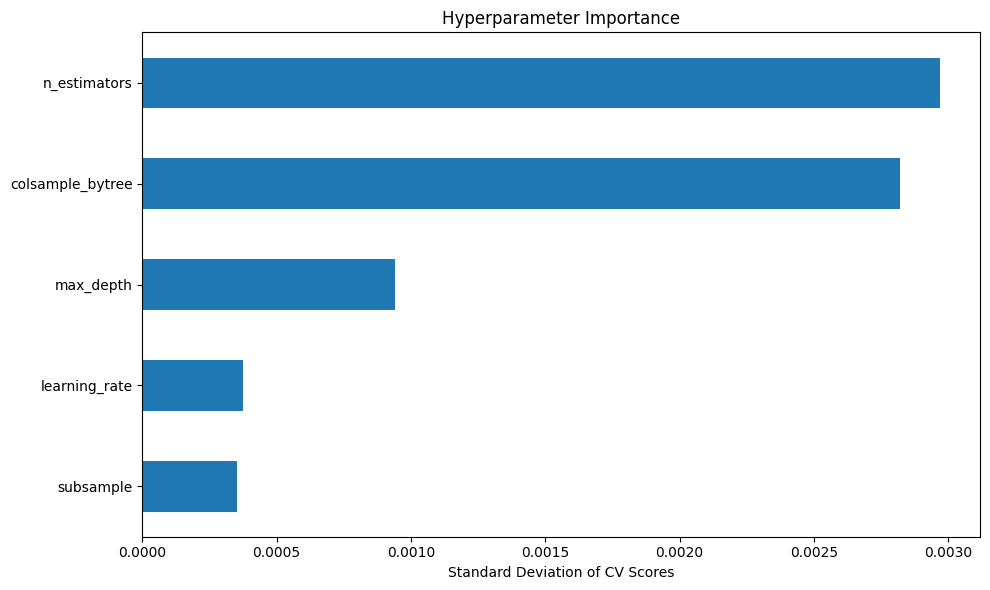

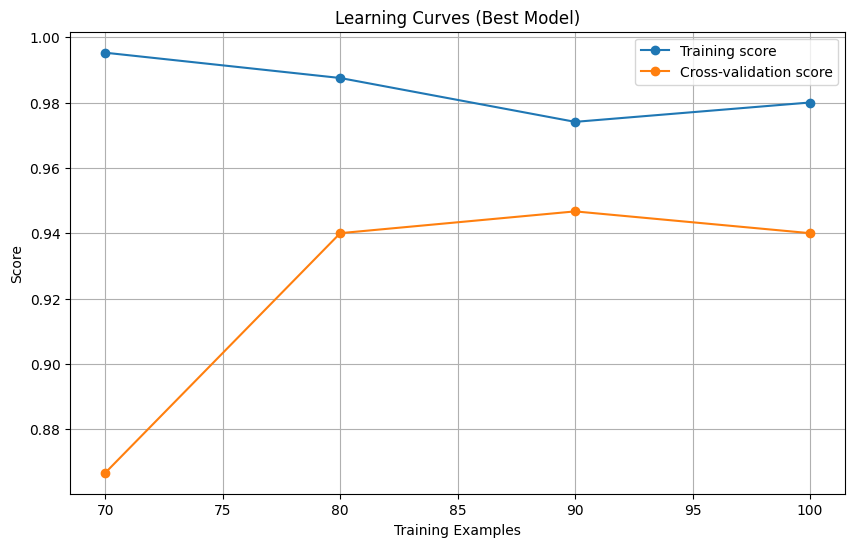

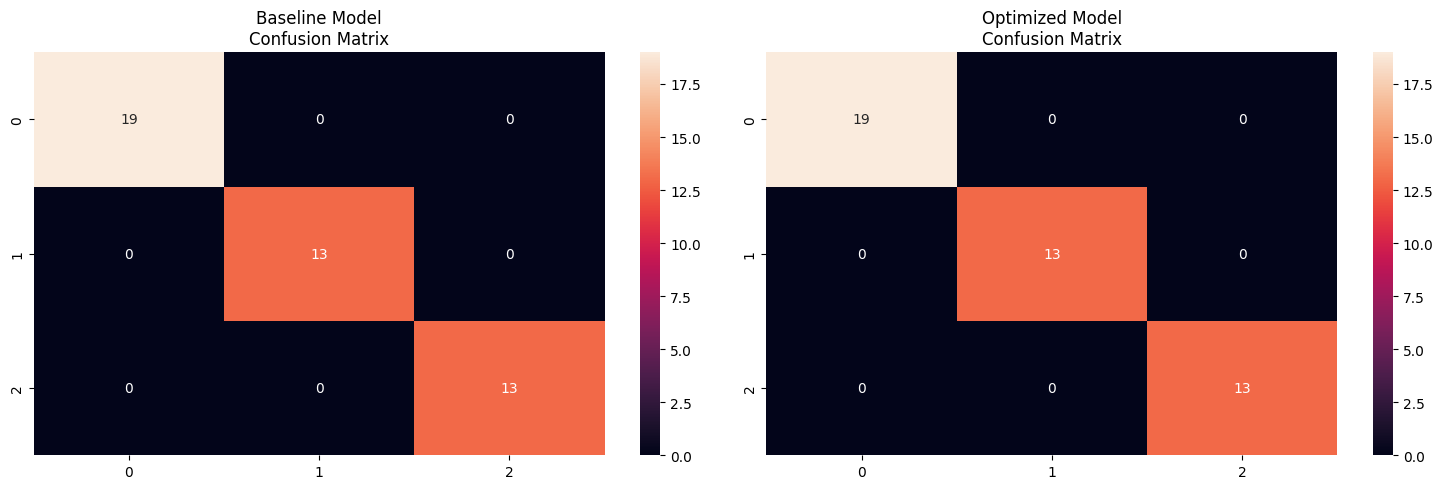

In [ ]:
# Evaluate optimized model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred)

print("\nModel Performance Comparison:")
print(f"Baseline Accuracy: {baseline_accuracy:.3f}")
print(f"Optimized Accuracy: {optimized_accuracy:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize hyperparameter importance
# =====================================

def plot_param_importance():
    results = pd.DataFrame(grid_search.cv_results_)

    # Calculate mean score for each parameter
    param_importance = {}
    for param in param_grid.keys():
        scores = []
        for value in param_grid[param]:
            mask = results[f'param_{param}'].astype(str) == str(value)
            scores.append(results.loc[mask, 'mean_test_score'].mean())
        param_importance[param] = np.std(scores)

    # Plot parameter importance
    plt.figure(figsize=(10, 6))
    importance_df = pd.Series(param_importance).sort_values()
    importance_df.plot(kind='barh')
    plt.title('Hyperparameter Importance')
    plt.xlabel('Standard Deviation of CV Scores')
    plt.tight_layout()
    plt.show()

plot_param_importance()

# Learning curves for best model
# =====================================

from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curves(best_model, X, y, 'Learning Curves (Best Model)')

# Confusion matrix visualization
# =====================================

def plot_confusion_matrices():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Baseline model confusion matrix
    cm_baseline = confusion_matrix(y_test, baseline_pred)
    sns.heatmap(cm_baseline, annot=True, fmt='d', ax=ax1)
    ax1.set_title('Baseline Model\nConfusion Matrix')

    # Optimized model confusion matrix
    cm_optimized = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_optimized, annot=True, fmt='d', ax=ax2)
    ax2.set_title('Optimized Model\nConfusion Matrix')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices()